In [5]:
#pip install mendeleev
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from mendeleev import element
import math

In [6]:
##creating Atom class
class Atom:
    def __init__(self, atType, symbol, userNum, coords, id = -1):
        self.atType = atType
        self.symbol = symbol
        self.userNum = userNum
        self.coords = coords
        self.id = id
        xyz = coords.split()
        self.xcoord = float(xyz[0])
        self.ycoord = float(xyz[1])
        self.zcoord = float(xyz[2])
        
    def __repr__(self):
        return "Atom: id: {}, atType: {}, symbol: {}, userNum: {}, coords: {}".format(self.id, self.atType, self.symbol, self.userNum, self.coords)

##creating Bond class
class Bond:
    def __init__(self, bondAtom1, bondAtom2, bondOrderType, bondOrder):
        self.bondAtom1 = bondAtom1
        self.bondAtom2 = bondAtom2
        self.bondOrderType = bondOrderType
        self.bondOrder = bondOrder
        
    def __repr__(self):
        return " Bond: bondAtom1: {}, bondAtom2: {}, bondOrderType: {}, bondOrder: {}".format(self.bondAtom1, self.bondAtom2, self.bondOrderType, self.bondOrder)

##creating Molecule class
class Molecule:
    
    ##initializer with option to parse c3xml file
    def __init__(self, file=None):
        self.atoms = dict()
        self.bonds = dict()
        if file == None:
            pass
            ##creates empty molecule, atoms and bonds can be added later on
        else:
            tree = ET.parse(file)
            root = tree.getroot()
            for atom in root.iter('atom'):
                id = atom.attrib['id']
                atType = atom.attrib['atType']
                symbol = atom.attrib['symbol']
                userNum = atom.attrib['userNum']
                coords = atom.attrib['cartCoords']
                self.atoms[id] = Atom(atType, symbol, userNum, coords, id)
            for bond in root.iter('bond'):
                id = bond.attrib['id']
                bondAtom1 = bond.attrib['bondAtom1']
                bondAtom2 = bond.attrib['bondAtom2']
                bondOrderType = bond.attrib['bondOrderType']
                bondOrder = bond.attrib['bondOrder']
                self.bonds[id] = Bond(bondAtom1, bondAtom2, bondOrderType, bondOrder)
        self.center = None
        #only for k-hop function
    
    def __repr__(self):
        return "Atoms: {}, Bonds: {}".format(self.atoms.keys(), self.bonds.keys())
    
    def bond_atom1(self, bond):
        return self.bonds[bond].bondAtom1
    
    def bond_atom2(self, bond):
        return self.bonds[bond].bondAtom2
    
    def bond_atom1_info(self, bond):
        return self.atoms[self.bonds[bond].bondAtom1]
    
    def bond_atom2_info(self, bond):
        return self.atoms[self.bonds[bond].bondAtom2]
    
    def plot(self):
        fig = plt.figure(figsize = (20,15))
        ax = plt.axes(projection = '3d')
    
        x = np.array([])
        y = np.array([])
        z = np.array([])
        
        symbol_colors = {'C': 'black', 'H': 'gray', 'O': 'red', 'N': 'blue', "Cl": 'green', 'S': 'yellow', 'P': 'orange', 'F': 'indigo'}
        
        atoms_dict_x = dict()
        atoms_dict_y = dict()
        atoms_dict_z = dict()
        for atom in self.atoms:
            if self.atoms[atom].symbol not in atoms_dict_x.keys():
                atoms_dict_x[self.atoms[atom].symbol] = np.array([])
                atoms_dict_y[self.atoms[atom].symbol] = np.array([])
                atoms_dict_z[self.atoms[atom].symbol] = np.array([])
            else:
                pass
            atoms_dict_x[self.atoms[atom].symbol] = np.append(atoms_dict_x[self.atoms[atom].symbol], self.atoms[atom].xcoord)
            atoms_dict_y[self.atoms[atom].symbol] = np.append(atoms_dict_y[self.atoms[atom].symbol], self.atoms[atom].ycoord)
            atoms_dict_z[self.atoms[atom].symbol] = np.append(atoms_dict_z[self.atoms[atom].symbol], self.atoms[atom].zcoord)
        for symbol in atoms_dict_x.keys():
            if symbol != 'Lp':
                if symbol in symbol_colors.keys():
                    color = symbol_colors[symbol]
                else:
                    color = 'magenta'
                size = 5 * element(symbol).atomic_radius
                ax.scatter(atoms_dict_x[symbol], atoms_dict_y[symbol], atoms_dict_z[symbol], s = size, c = color)
        ##plotting atoms
    
        bond_width = {'0':0,'1': 2, "2":6, "3":12}
        #none, single bond, double bond, triple bond
        for bond in self.bonds:
            xb = np.array([])
            yb = np.array([])
            zb = np.array([])
            xb = np.append(xb, self.atoms[self.bonds[bond].bondAtom1].xcoord)
            xb = np.append(xb, self.atoms[self.bonds[bond].bondAtom2].xcoord)
            yb = np.append(yb, self.atoms[self.bonds[bond].bondAtom1].ycoord)
            yb = np.append(yb, self.atoms[self.bonds[bond].bondAtom2].ycoord)
            zb = np.append(zb, self.atoms[self.bonds[bond].bondAtom1].zcoord)
            zb = np.append(zb, self.atoms[self.bonds[bond].bondAtom2].zcoord)
            ax.plot(xb, yb, zb, linewidth = bond_width[self.bonds[bond].bondOrder], c = 'gray')
        
    
    ##returns atoms & bonds one hop from given atom, used later to construct the k-hop method
    def one_hop(self, atom):
        one_hop = []
        one_hop.append(atom)
        one_hop_bonds = []
        for bond in self.bonds.keys():
            if self.bond_atom1(bond) == atom:
                one_hop.append(self.bond_atom2(bond))
                one_hop_bonds.append(bond)
            elif self.bond_atom2(bond) == atom:
                one_hop.append(self.bond_atom1(bond))
                one_hop_bonds.append(bond)
        return one_hop, one_hop_bonds
    
    ##built this first to use as a guide to build k-hop method
    #def two_hop(self, atom):
        #atoms, bonds = self.one_hop(atom)
        #two_hop = []
        #two_hop_bonds = []
        #for atom in atoms:
            #two_hop.append(atom)
        #for bond in bonds:
            #two_hop_bonds.append(bond)
        #for i in atoms:
            #a, b = self.one_hop(i)
            #for atom in a:
                #if atom not in two_hop:
                    #two_hop.append(atom)
            #for bond in b:
                #if bond not in two_hop_bonds:
                    #two_hop_bonds.append(bond)
        #return two_hop, two_hop_bonds
    
    ##returns molecule with all atoms, bonds in a k-hop neighborhood of an atom
    def k_hop(self, atom, k):
        k_atoms, k_bonds = self.one_hop(atom)
        new_atoms = []
        new_bonds = []
        for iter in range(k-1):
            for i in k_atoms:
                atoms, bonds = self.one_hop(i)
                for atom in atoms:
                    if atom not in k_atoms and atom not in new_atoms:
                        new_atoms.append(atom)
                for bond in bonds:
                    if bond not in k_bonds and bond not in new_bonds:
                        new_bonds.append(bond) 
            for a in new_atoms:
                k_atoms.append(a)
            for b in new_bonds:
                k_bonds.append(b)
            new_atoms = []
            new_bonds = []
        new_molecule = Molecule()
        #added center, center_id 1/19
        new_molecule.center = self.atoms[atom]
        ####################### 
        for atom in k_atoms:
            new_molecule.atoms[atom] = self.atoms[atom]
        for bond in k_bonds:
            new_molecule.bonds[bond] = self.bonds[bond]
        return new_molecule
    
    ###new 1/19
    def get_all_k_hop(self, k):
        neighborhoods = []
        for atom in self.atoms:
            neighborhoods.append(self.k_hop(atom, k))
        return neighborhoods

    ###new 1/21
    def distance(self, bond):
        atom1 = self.bonds[bond].bondAtom1
        atom2 = self.bonds[bond].bondAtom2
        x1 = self.atoms[atom1].xcoord
        y1 = self.atoms[atom1].ycoord
        z1 = self.atoms[atom1].zcoord
        x2 = self.atoms[atom2].xcoord
        y2 = self.atoms[atom2].ycoord
        z2 = self.atoms[atom2].zcoord
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        return distance


In [95]:
files = pd.read_excel('chemfiles.xlsx')

In [8]:
folder = {
    'Addition of alcohols': '1 Addition of alcohols',
    'Addition of thiols': '2 Addition of thiols',
    'Hydrophosphonylation of imines': '3 Hydrophosphonylation of imines',
    'Addition of diazomethylphosphonates': '4 Addition of diazomethylphosphonates',
    'Addition of diazoacetamides': '5 Addition of diazoacetamides',
    'Strecker Reaction (with aldimines)': '6 Strecker Reaction (with aldimines)',
    'Peroxidation of imines': '7 Peroxidation of imines',
    'Transfer Hydrogenation of beta,gamma-Alkynyl alpha-Imino Esters': '8 Transfer Hydrogenation of beta,gamma-Alkynyl alpha-Imino Esters',
    'Transfer Hydrogenation of Enamides': '9 Transfer Hydrogenation of Enamides',
    'Transfer Hydrogenation of N-aryl imines (List)': '10 Transfer Hydrogenation of N-aryl imines (List)',
    'Transfer Hydrogenation of N-aryl imines (Rueping)': '11 Transfer Hydrogenation of N-aryl imines (Rueping)',
    'Reductive amination of N-aryl imines (Macmillan)': '12 Reductive amination of N-aryl imines (Macmillan)',
    'Transfer Hydrogenation of trifluoromethyl ketimines': '13 Transfer Hydrogenation of trifluoromethyl ketimines',
    'Transfer Hydrogenation of N-aryl imines by benzothiazoline': '14 Transfer Hydrogenation of N-aryl imines by benzothiazoline',
    'Reductive amination of aliphatic ketones by benzothiazoline': '15 Reductive amination of aliphatic ketones by benzothiazoline',
    'Transfer Hydrogenation of ethyl ketimines': '16 Transfer Hydrogenation of ethyl ketimines',
    'Strecker Reaction (with ketimines)': '17 Strecker Reaction (with ketimines)',
    'Addition of enecarbamates to benzoyl imines': '18 Addition of enecarbamates to benzoyl imines',
    'Hydrogenation of fluorinated alkynyl ketimines': '19 Hydrogenation of fluorinated alkynyl ketimines',
    'Addition of thiols to imines (Denmark)': '20 Addition of thiols to imines (Denmark)'
}

In [15]:
files.head()

,Unnamed: 0,reaction,category,entry,substrate1,substrate2,solvent,product,catalyst
0,0.0,Addition of alcohols,NaN,1,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 1.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 1.c3xml,Addition of alchohols - Catalyst.c3xml
1,1.0,Addition of alcohols,NaN,2,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 2.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 2.c3xml,Addition of alchohols - Catalyst.c3xml
2,2.0,Addition of alcohols,NaN,3,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 3.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 3.c3xml,Addition of alchohols - Catalyst.c3xml
3,3.0,Addition of alcohols,NaN,4,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 4.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 4.c3xml,Addition of alchohols - Catalyst.c3xml
4,4.0,Addition of alcohols,NaN,5,Addition of alchohols - Substrate 1 - 1-10.c3xml,Addition of alchohols - Substrate 2 - 5.c3xml,Addition of alchohols - Solvent.c3xml,Addition of alchohols - Product 5.c3xml,Addition of alchohols - Catalyst.c3xml


In [75]:
extra_bonds_sub1 = list()
single_bonds_sub1 = list()
double_bonds_sub1 = list()
triple_bonds_sub1 = list()
all_bonds_sub1 = list()

In [76]:
extra_bonds_sub2 = list()
single_bonds_sub2 = list()
double_bonds_sub2 = list()
triple_bonds_sub2 = list()
all_bonds_sub2 = list()

In [61]:
extra_bonds_sol = list()
single_bonds_sol = list()
double_bonds_sol = list()
triple_bonds_sol = list()
all_bonds_sol = list()

In [96]:
extra_bonds_pro = list()
single_bonds_pro = list()
double_bonds_pro = list()
triple_bonds_pro = list()
all_bonds_pro = list()

In [63]:
extra_bonds_cat = list()
single_bonds_cat = list()
double_bonds_cat = list()
triple_bonds_cat = list()
all_bonds_cat = list()

In [64]:
extra_bonds = list()
single_bonds = list()
double_bonds = list()
triple_bonds = list()
all_bonds = list()

In [77]:
##substrate 1
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,4]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 4]
    molecule = Molecule(filename)
    for bond in molecule.bonds:
        if molecule.bonds[bond].bondOrder == '1':
            single_bonds_sub1.append(molecule.distance(bond))
            all_bonds_sub1.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '2':
            double_bonds_sub1.append(molecule.distance(bond))
            all_bonds_sub1.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '3':
            triple_bonds_sub1.append(molecule.distance(bond))
            all_bonds_sub1.append(molecule.distance(bond))
        else:
            extra_bonds_sub1.append(molecule.distance(bond))

In [102]:
print(len(single_bonds_sub1))
print(len(double_bonds_sub1))
print(len(triple_bonds_sub1))
print(len(all_bonds_sub1))
print(len(extra_bonds_sub1))

11329
3086
39
14454
0


In [78]:
##substrate 2
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,5]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 5]
    molecule = Molecule(filename)
    for bond in molecule.bonds:
        if molecule.bonds[bond].bondOrder == '1':
            single_bonds_sub2.append(molecule.distance(bond))
            all_bonds_sub2.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '2':
            double_bonds_sub2.append(molecule.distance(bond))
            all_bonds_sub2.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '3':
            triple_bonds_sub2.append(molecule.distance(bond))
            all_bonds_sub2.append(molecule.distance(bond))
        else:
            extra_bonds_sub2.append(molecule.distance(bond))

In [103]:
print(len(single_bonds_sub2))
print(len(double_bonds_sub2))
print(len(triple_bonds_sub2))
print(len(all_bonds_sub2))
print(len(extra_bonds_sub2))

8678
1520
47
10245
0


In [82]:
##solvent
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,6]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 6]
    molecule = Molecule(filename)
    for bond in molecule.bonds:
        if molecule.bonds[bond].bondOrder == '1':
            single_bonds_sol.append(molecule.distance(bond))
            all_bonds_sol.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '2':
            double_bonds_sol.append(molecule.distance(bond))
            all_bonds_sol.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '3':
            triple_bonds_sol.append(molecule.distance(bond))
            all_bonds_sol.append(molecule.distance(bond))
        else:
            extra_bonds_sol.append(molecule.distance(bond))

In [104]:
print(len(single_bonds_sol))
print(len(double_bonds_sol))
print(len(triple_bonds_sol))
print(len(all_bonds_sol))
print(len(extra_bonds_sol))

4779
970
2
5751
0


In [97]:
##product
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,7]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 7]
    molecule = Molecule(filename)
    for bond in molecule.bonds:
        if molecule.bonds[bond].bondOrder == '1':
            single_bonds_pro.append(molecule.distance(bond))
            all_bonds_pro.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '2':
            double_bonds_pro.append(molecule.distance(bond))
            all_bonds_pro.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '3':
            triple_bonds_pro.append(molecule.distance(bond))
            all_bonds_pro.append(molecule.distance(bond))
        else:
            extra_bonds_pro.append(molecule.distance(bond))

In [105]:
print(len(single_bonds_pro))
print(len(double_bonds_pro))
print(len(triple_bonds_pro))
print(len(all_bonds_pro))
print(len(extra_bonds_pro))

16371
3252
65
19688
0


In [100]:
##catalyst
for i in range(444):
    if pd.isna(files.iloc[i,2]) == True:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i,8]
    else:
        filename = '/Users/jlisd/Downloads/AI_Chem/Chem3D/'+ folder[files.iloc[i, 1]] + '/' + files.iloc[i, 2] + '/' + files.iloc[i, 8]
    molecule = Molecule(filename)
    for bond in molecule.bonds:
        if molecule.bonds[bond].bondOrder == '1':
            single_bonds_cat.append(molecule.distance(bond))
            all_bonds_cat.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '2':
            double_bonds_cat.append(molecule.distance(bond))
            all_bonds_cat.append(molecule.distance(bond))
        elif molecule.bonds[bond].bondOrder == '3':
            triple_bonds_cat.append(molecule.distance(bond))
            all_bonds_cat.append(molecule.distance(bond))
        else:
            extra_bonds_cat.append(molecule.distance(bond))

In [106]:
print(len(single_bonds_cat))
print(len(double_bonds_cat))
print(len(triple_bonds_cat))
print(len(all_bonds_cat))
print(len(extra_bonds_cat))

36289
8656
0
44945
0


In [112]:
single_bonds = single_bonds_sub1 + single_bonds_sub2 + single_bonds_sol + single_bonds_pro + single_bonds_cat
double_bonds = double_bonds_sub1 + double_bonds_sub2 + double_bonds_sol + double_bonds_pro + double_bonds_cat
triple_bonds = triple_bonds_sub1 + triple_bonds_sub2 + triple_bonds_sol + triple_bonds_pro + triple_bonds_cat
all_bonds = all_bonds_sub1 + all_bonds_sub2 + all_bonds_sol + all_bonds_pro + all_bonds_cat

In [113]:
print(len(single_bonds))
print(len(double_bonds))
print(len(triple_bonds))
print(len(all_bonds))

77446
17484
153
95083


(array([4.8300e+02, 3.0600e+02, 5.0600e+02, 3.9868e+04, 9.8000e+01,
        9.5000e+02, 1.0780e+03, 1.2160e+04, 2.0803e+04, 7.1000e+03,
        1.2560e+03, 8.2090e+03, 0.0000e+00, 1.5220e+03, 0.0000e+00,
        1.1200e+02, 2.1200e+02, 2.7600e+02, 1.4200e+02, 2.0000e+00]),
 array([0.9419916 , 0.99234227, 1.04269295, 1.09304363, 1.1433943 ,
        1.19374498, 1.24409565, 1.29444633, 1.344797  , 1.39514768,
        1.44549836, 1.49584903, 1.54619971, 1.59655038, 1.64690106,
        1.69725174, 1.74760241, 1.79795309, 1.84830376, 1.89865444,
        1.94900512]),
 <a list of 20 Patch objects>)

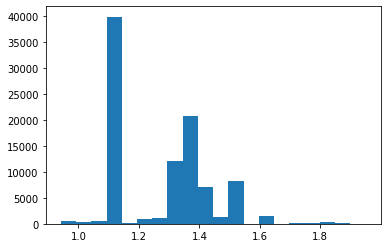

In [115]:
plt.hist(all_bonds, bins = 20)